In [2]:
import numpy as np # linear algebra
import pandas as pd

In [8]:
df = pd.read_csv("/content/goalkeepers_with_saves_and_conceded.csv")
df = df.drop(['country_of_citizenship', 'name', 'current_club_name',"position","current_club_domestic_competition_id"], axis=1)

display(df.head())

,foot,height_in_cm,market_value_in_eur,yellow_cards,red_cards,minutes_played,age,saves,goals_conceded
0,left,197.0,45000000.0,3,1,3285,24,164,31
1,right,186.0,45000000.0,0,1,3785,25,151,58
2,right,196.0,40000000.0,5,1,3340,25,105,55
3,right,196.0,40000000.0,1,0,3716,27,156,57
4,right,191.0,38000000.0,3,1,3702,29,187,25


In [29]:
# =========================================
# Preprocessing for Attacker Market Value Data (with Per-90 Stats)
# =========================================

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Define target and feature columns ---
target = 'market_value_in_eur'

numeric_features = [
    'height_in_cm', 'yellow_cards',
    'red_cards', 'minutes_played', 'age', 'saves', 'goals_conceded'
]

categorical_features = ['foot']

# --- Create a copy to avoid modifying original ---
df_copy = df.copy()

# --- ✅ Add per-90 statistics ---
# Prevent division by zero by replacing 0 minutes with NaN
df_copy['minutes_played'] = df_copy['minutes_played'].replace(0, pd.NA)

df_copy['goals_conceded_per_90'] = df_copy['goals_conceded'] / (df_copy['minutes_played'] / 90)
df_copy['saves_per_90'] = df_copy['saves'] / (df_copy['minutes_played'] / 90)
df_copy['yellow_cards_per_90'] = df_copy['yellow_cards'] / (df_copy['minutes_played'] / 90)
df_copy['red_cards_per_90'] = df_copy['red_cards'] / (df_copy['minutes_played'] / 90)

# Fill any NaNs (from players with 0 minutes) with 0
df_copy.fillna(0, inplace=True)

# --- Extend numeric feature list with new features ---
numeric_features += [
    'goals_conceded_per_90',
    'saves_per_90',
    'yellow_cards_per_90',
    'red_cards_per_90'
]

# --- Split features and target ---
X = df_copy.drop(columns=[target])
y = df_copy[target]

# --- Define preprocessing transformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Fit and transform features ---
X_processed = preprocessor.fit_transform(X)

# --- Get encoded categorical column names ---
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

# --- Convert back to DataFrame ---
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# --- Combine with target for inspection ---
df_processed = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

print("✅ Preprocessing complete with per-90 stats!")
print("Processed features shape:", X_processed_df.shape)
print("Final dataframe shape (with target):", df_processed.shape)

# Drop any unnecessary one-hot columns if needed
if 'foot_both' in df_processed.columns:
    df_processed = df_processed.drop(['foot_both'], axis=1)
df_processed = df_processed.drop(['goals_conceded', 'saves', 'yellow_cards', 'red_cards'],axis=1)

df_processed.head()


✅ Preprocessing complete with per-90 stats!
Processed features shape: (559, 14)
Final dataframe shape (with target): (559, 15)


,height_in_cm,minutes_played,age,goals_conceded_per_90,saves_per_90,yellow_cards_per_90,red_cards_per_90,foot_left,foot_right,market_value_in_eur
0,1.503049,1.399312,-0.977023,-0.031444,1.447100,0.185913,1.586176,1.0,0.0,45000000.0
1,-1.152769,1.792508,-0.780210,1.319922,0.426437,-0.527460,1.355920,0.0,1.0,45000000.0
2,1.261611,1.442563,-0.780210,1.582404,-0.434211,0.641916,1.557474,0.0,1.0,40000000.0
3,1.261611,1.738247,-0.386584,1.323464,0.638751,-0.317249,-0.156866,0.0,1.0,40000000.0
4,0.054421,1.727238,0.007042,-0.647516,1.507074,0.105557,1.389837,0.0,1.0,38000000.0


In [34]:
# X_processed_df = X_processed_df.drop(['foot_both'], axis=1)
X_processed_df = X_processed_df.drop(['goals_conceded', 'saves', 'yellow_cards', 'red_cards'],axis=1)
X_processed_df.head()

,height_in_cm,minutes_played,age,goals_conceded_per_90,saves_per_90,yellow_cards_per_90,red_cards_per_90,foot_left,foot_right
0,1.503049,1.399312,-0.977023,-0.031444,1.447100,0.185913,1.586176,1.0,0.0
1,-1.152769,1.792508,-0.780210,1.319922,0.426437,-0.527460,1.355920,0.0,1.0
2,1.261611,1.442563,-0.780210,1.582404,-0.434211,0.641916,1.557474,0.0,1.0
3,1.261611,1.738247,-0.386584,1.323464,0.638751,-0.317249,-0.156866,0.0,1.0
4,0.054421,1.727238,0.007042,-0.647516,1.507074,0.105557,1.389837,0.0,1.0


In [39]:
# =========================================
# Advanced Stacking (RF + CatBoost + Linear Regression)
# =========================================
!pip install --quiet catboost
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

# --- Split data ---
X = X_processed_df
y = df_processed['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================
# 1️⃣ Base models
# =========================================

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

cat = CatBoostRegressor(
    iterations=700,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    random_state=42,
    verbose=0
)

lr = LinearRegression()

estimators = [
    ('rf', rf),
    ('cat', cat),
    ('lr', lr)
]

# =========================================
# 2️⃣ Meta-model (final estimator)
# =========================================

meta_model = GradientBoostingRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# =========================================
# 3️⃣ Stacking Regressor (5-fold CV)
# =========================================

stacked = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    passthrough=True,
    n_jobs=-1
)

# =========================================
# 4️⃣ Train and Evaluate
# =========================================

stacked.fit(X_train, y_train)
y_pred = stacked.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("✅ Stacked Model Performance (with CatBoost):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# =========================================
# 5️⃣ Compare Individual Base Models
# =========================================
print("\n📊 Base Model Comparison:")
for name, model in estimators:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{name.upper():4s} R²: {r2_score(y_test, pred):.4f}")


✅ Stacked Model Performance (with CatBoost):
R² Score: 0.3353
MAE: 3388185.28
RMSE: 6644334.35

📊 Base Model Comparison:
RF   R²: 0.3218
CAT  R²: 0.2332
LR   R²: 0.2868


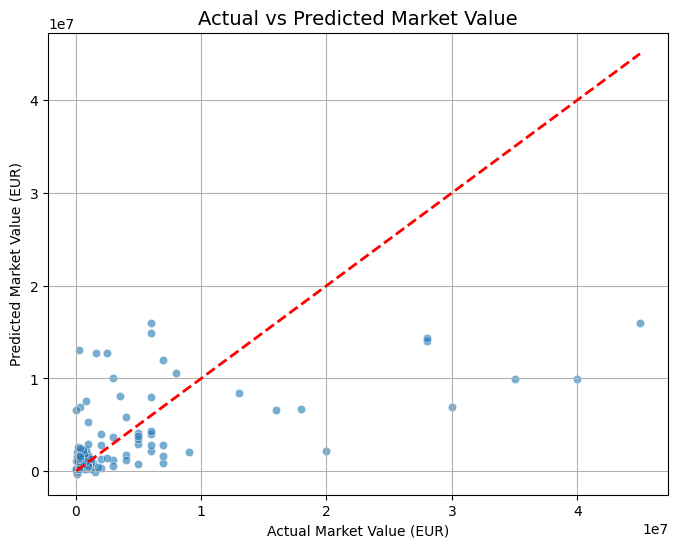

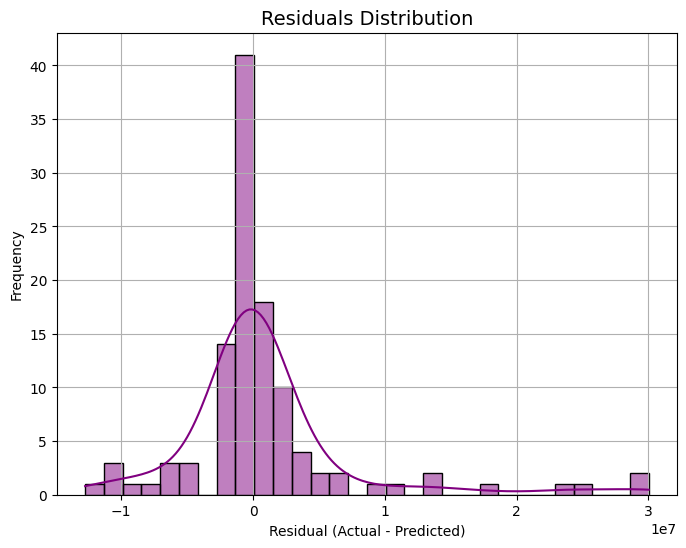

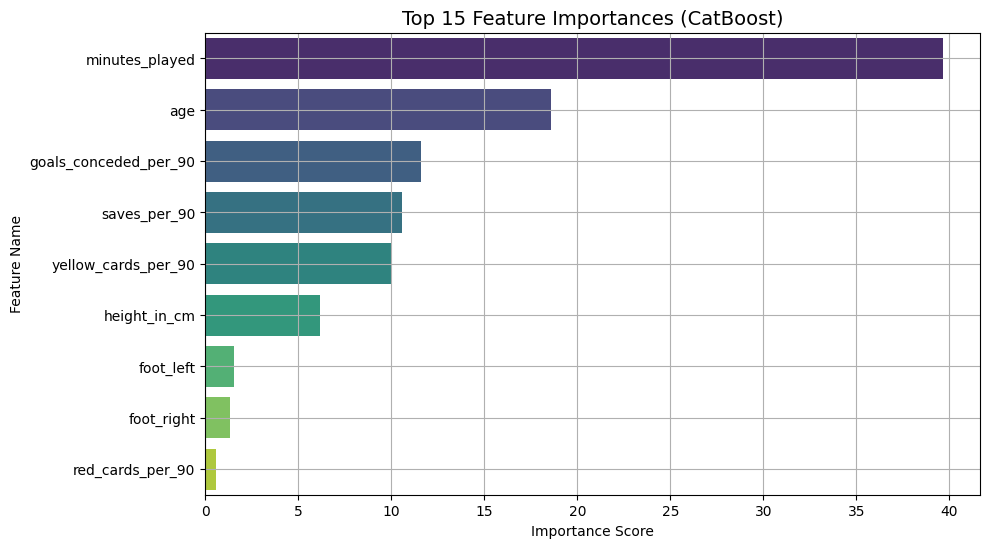

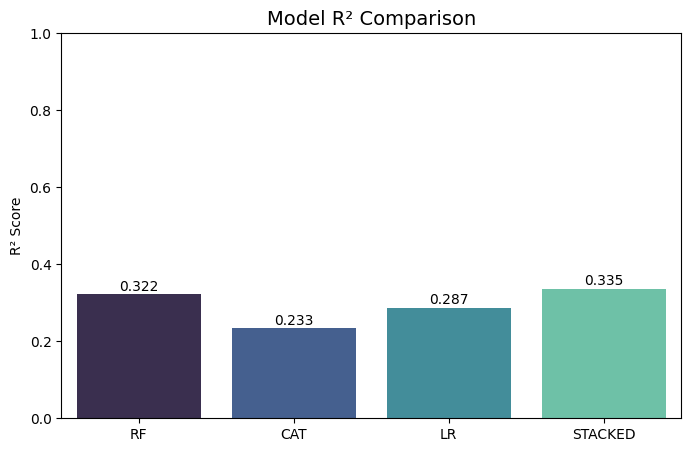

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

# --- 1️⃣ Actual vs Predicted Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Market Value', fontsize=14)
plt.xlabel('Actual Market Value (EUR)')
plt.ylabel('Predicted Market Value (EUR)')
plt.grid(True)
plt.show()

# --- 2️⃣ Residuals Distribution ---
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Residuals Distribution', fontsize=14)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- 3️⃣ Feature Importance (from CatBoost) ---
cat.fit(X_train, y_train)
importances = cat.get_feature_importance()
features = X.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (CatBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.grid(True)
plt.show()

# --- 4️⃣ Model Comparison (R² Bar Plot) ---
model_scores = {}
for name, model in estimators:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_scores[name.upper()] = r2_score(y_test, pred)

model_scores['STACKED'] = r2_score(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette='mako')
plt.title('Model R² Comparison', fontsize=14)
plt.ylabel('R² Score')
plt.ylim(0, 1)
for i, v in enumerate(model_scores.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.show()


In [42]:
import joblib

# Save model to file
joblib.dump(stacked, "stacked_model_gk_value.pkl")

print("✅ Model saved successfully as 'stacked_model_gk_value.pkl'")



✅ Model saved successfully as 'stacked_model_gk_value.pkl'
